In [146]:
import numpy as np
import pandas as pd
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift

Perform H Band reduction

In [28]:
# Set up paths 
frameSize = 351
band = 'H'
tg_name= '2M1207'
useRefFrames = False
path_input = '/home/ubuntu/Downloads/2M1207_bands/Hband/'
path_output = path_input + 'out/'
sep='/'
print(path_input)

path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

/home/ubuntu/Downloads/2M1207_bands/Hband/


In [29]:
# File list
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_54_41.920.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_56_08.901.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_57_35.981.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_59_03.178.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_00_51.350.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_02_18.216.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_03_44.710.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_05_11.355.fits']


# H BAND RAW IMAGE

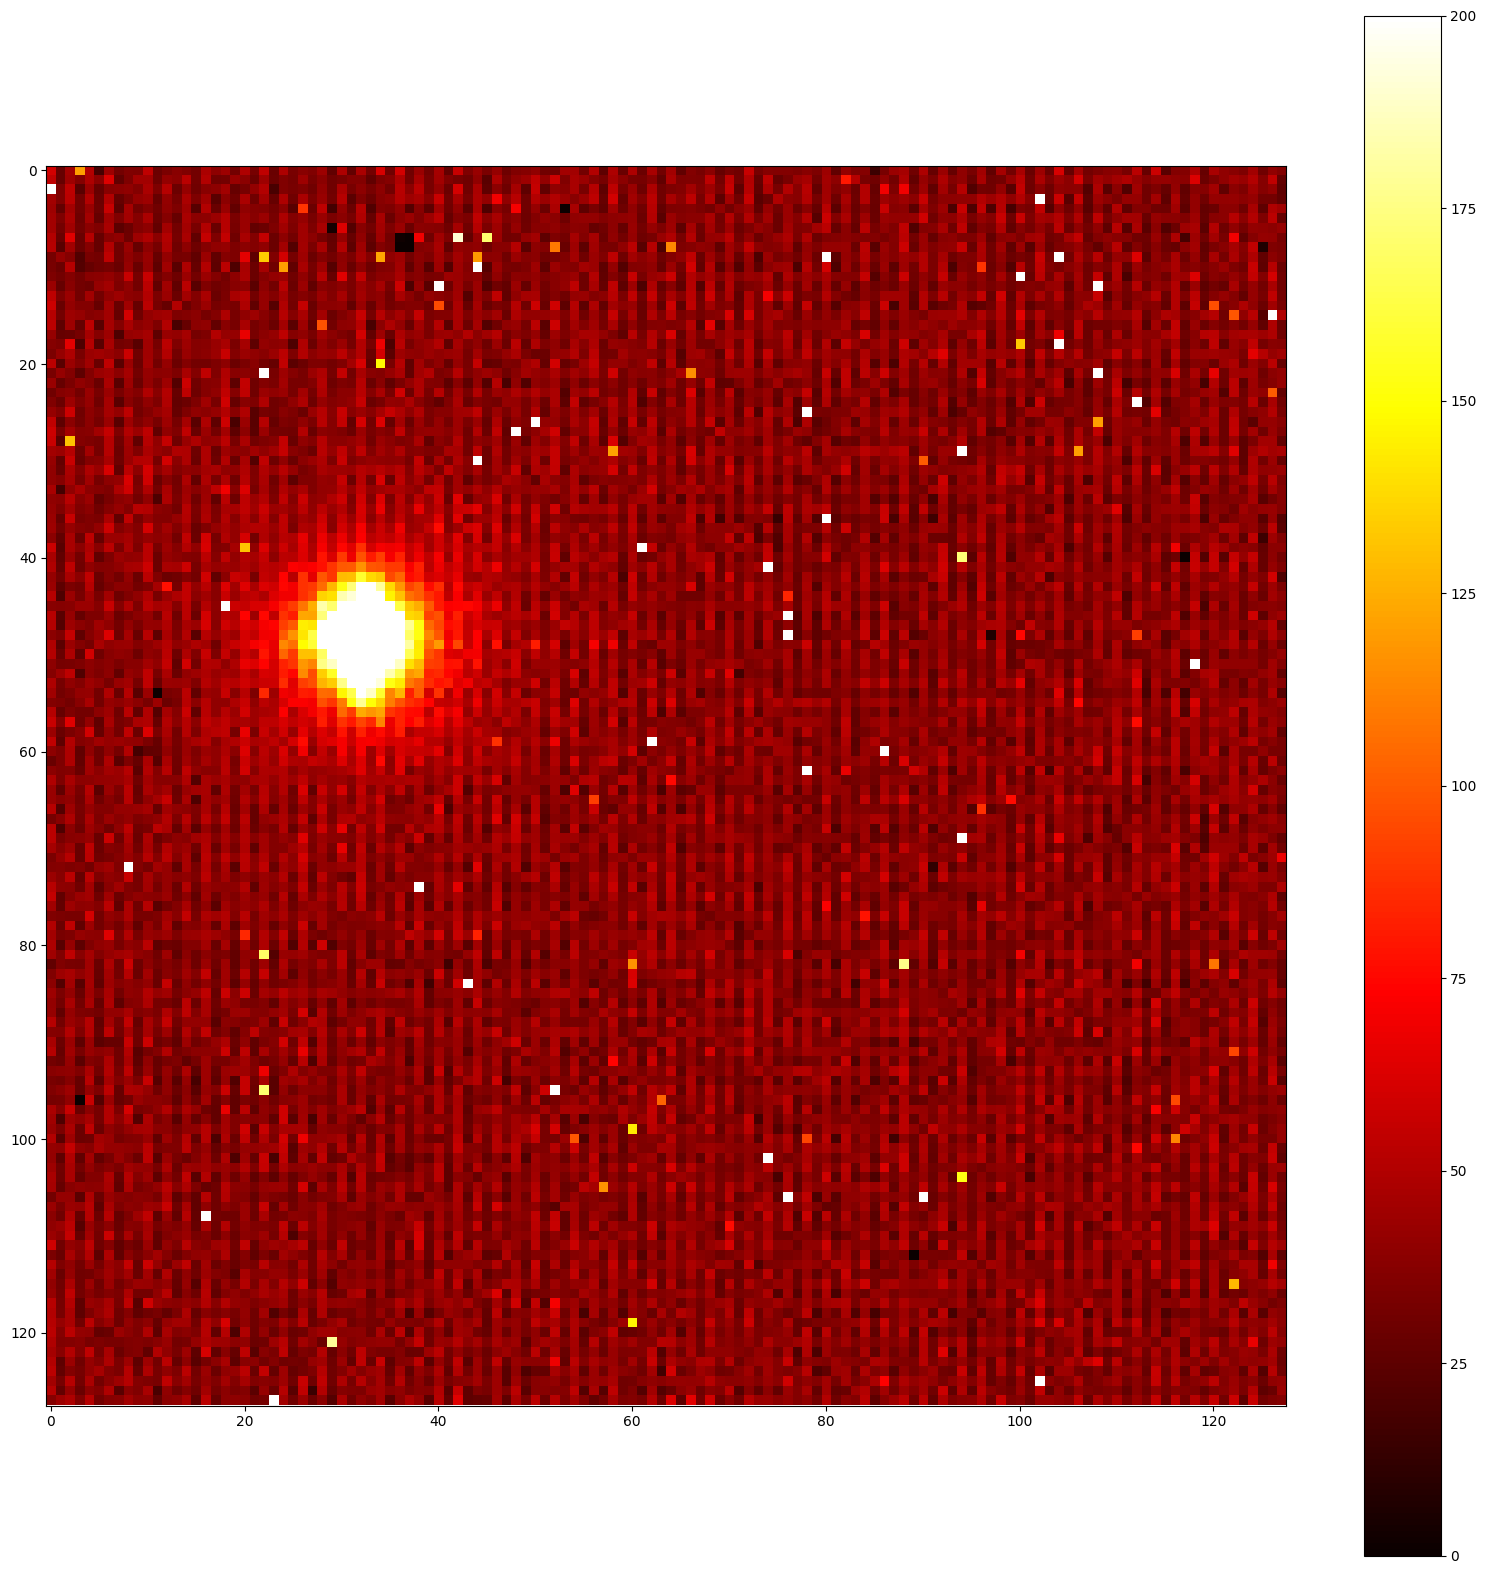

In [30]:
raw_sci = fits.open(filelist_sci[0])[0].data
crop = 128
dimx = raw_sci.shape[0]
dimy = raw_sci.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
raw_sci = shift(raw_sci,[-100,-100])
raw_cropped = raw_sci[x1:x2,y1:y2]
raw_cropped.shape
plt.figure(figsize=(20,20))
plt.imshow(raw_cropped,vmin=0,vmax=200,cmap='hot')
plt.colorbar()
plt.show();

The above pixel values are simply what were measured on the CCD when attempting to observe the exoplanet 2M1207, with no editing or corrections yet. 

We wrote a function to crop a given frame to crop the darks, flats, and biases as well as to make sure they are cropped the same way as the raw science frame.  

In [31]:
def crop(image, crop = 128):
    dimx, dimy = image.shape[0], image.shape[1]
    x1, y1 = int((dimx - crop)/2), int((dimy - crop)/2) 
    x2, y2 = int(x1 + crop), int(y1 + crop)
    image = shift(image, [-100,-100])
    return image[x1:x2,y1:y2]

## H BAND MASTER FLAT

The function get_frames retrieves all of the frames for a given band. The options are one of the following strings: "Hband", "Jband", "Kband", or "Lband" since those are the names of the directories for each wavelength band.

The function get_frames returns a dictionary. To access the flats simply use frames_dict['flats']

The function get_frames_dir is a helper function that reads every .fits file for each type of exposure: 'flats' , 'dark flats' which have a different exposure as reported above, 'sci' for science, and 'darks'. 

In [105]:
def get_frames(band, path_input = '/home/ubuntu/Downloads/2M1207_bands/',
             sep = '/'):
    frames_dict = {}
    path_input = path_input + band + sep
    frames_dict['flats'] = get_frames_from_dir(path_input+'flats'+sep)
    frames_dict['flat darks'] = get_frames_from_dir(path_input+'flats' + sep + 'darks'+sep)
    frames_dict['sci'] = get_frames_from_dir(path_input+'sci' + sep)
    frames_dict['darks'] = get_frames_from_dir(path_input+'darks' + sep)
    return frames_dict

def get_frames_from_dir(dir_path):
    frame_paths = glob.glob(dir_path + '*.fits')
    return [fits.open(frame_paths[file_num])[0].data
                for file_num in range(len(frame_paths))]

jband_dict, hband_dict = get_frames("Jband"), get_frames("Hband")
kband_dict, lband_dict = get_frames("Kband"), get_frames("Lband")
hband_dict['darks']

[array([[ 137.66667 ,  117.166664,  112.666664, ...,  136.16667 ,
          124.5     ,  218.33333 ],
        [  66.166664,   53.333332,   74.666664, ...,   37.833332,
           60.5     ,   44.333332],
        [  57.166668,   63.833332,  117.      , ...,   70.833336,
          145.5     ,   54.333332],
        ...,
        [  41.833332,    0.      ,   60.833332, ...,   27.      ,
           54.166668,   29.833334],
        [  55.166668,  -53.166668,   33.166668, ...,   23.833334,
           41.666668,   -0.5     ],
        [ -12.      , -166.5     ,  -20.166666, ...,  -60.166668,
          -18.833334,  378.66666 ]], dtype='>f4'),
 array([[ 137.33333  ,  115.833336 ,  113.5      , ...,  142.16667  ,
          121.833336 ,  217.83333  ],
        [  66.       ,   55.333332 ,   76.333336 , ...,   44.333332 ,
           58.       ,   46.       ],
        [  55.166668 ,   62.5      ,  117.       , ...,   73.       ,
          141.       ,   57.       ],
        ...,
        [  53.5      , 

https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html 

mad_std is the median absolute deviation (1.4826 times larger than the standard deviation for a normal distribution) and is 
\begin{align}
\text{MAD} = \text{median}(|X_i - \text{median}(X)|)
\end{align}

https://photutils.readthedocs.io/en/stable/detection.html

https://stackoverflow.com/questions/62926893/finding-median-value-of-multiple-numpy-arrays

### H BAND MASTER DARK FLAT
     
 Here we take the difference between a dark and a dark flat to be that the dark flat has a longer exposure time. We verify this below

In [123]:
#type(test_flat[0]), type(median_hband_flat)
test_path = path_input + '/flats/darks/'
test_file = 'NACO.2004-04-29T11_38_58.492.fits'
with fits.open(test_path + test_file) as hdul:
    #hdul.info()
    print("For the Hband flat darks we have for the exposure time in seconds: " + 
          str(hdul[0].header.tostring().split("EXPTIME = ")[-1].split("/")[0]) ) 
    #print(dir(hdul[0].header))

For the Hband flat darks we have for the exposure time in seconds:                1.200 


In [124]:
test_path = path_input + '/darks/'
test_file = 'NACO.2004-04-27T10_58_43.506.fits'
with fits.open(test_path + test_file) as hdul:
    print("For the Hband darks we have for the exposure time in seconds: " + 
          str(hdul[0].header.tostring().split("EXPTIME = ")[-1].split("/")[0]) ) 

For the Hband darks we have for the exposure time in seconds:               30.000 


Which is the integration time reported in the original publication: https://doi.org/10.1051/0004-6361:200400056

This function returns a new frame where each pixel value is the median of each corresponding pixel value from a given array of frames.

In [119]:
def get_median_frame(array_of_frames):
    stacked_frames = np.stack([crop(frame) for frame in array_of_frames])
    return np.median(stacked_frames, axis=0)

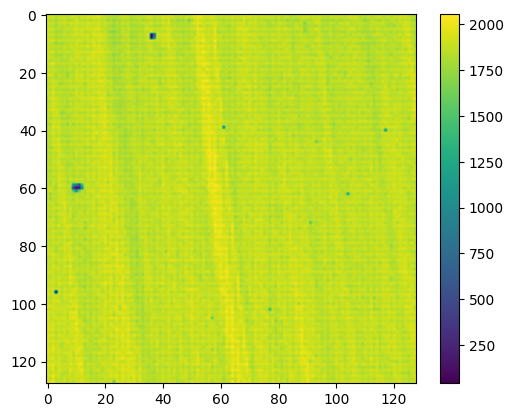

In [128]:
median_hband_flat = get_median_frame(hband_dict["flats"])
plt.imshow(median_hband_flat)
plt.colorbar()

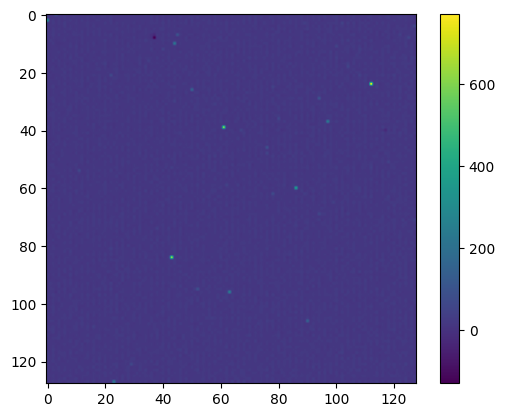

In [129]:
median_hband_short_dark = get_median_frame(hband_dict["flat darks"])
plt.imshow(median_hband_flat_dark)
plt.colorbar()

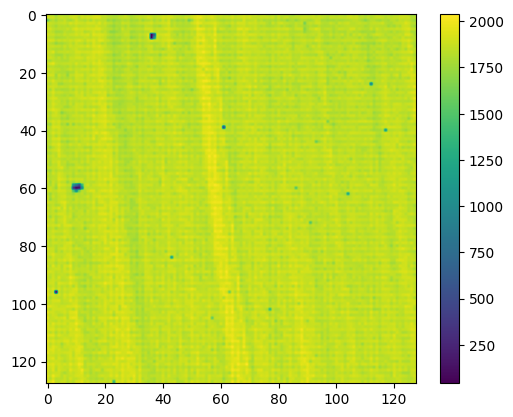

In [130]:
median_hband_reduced_flat =  median_hband_flat - median_hband_flat_dark
plt.imshow(median_hband_reduced_flat)
plt.colorbar()

We will only subtract the dark flat from the flats in order to arrive at the flats we will use for the data reduction for each wavelength band, as shown above.

Now we will proceed by reducing the hband wavelength frames using the following method.
\begin{align}
\text{reduced} = \frac{\text{science} - \text{dark}}{\text{flat}-\text{bias}}
\end{align}
where we perform this formula on each corresponding pixel in each frame. 

## Hband Master Dark

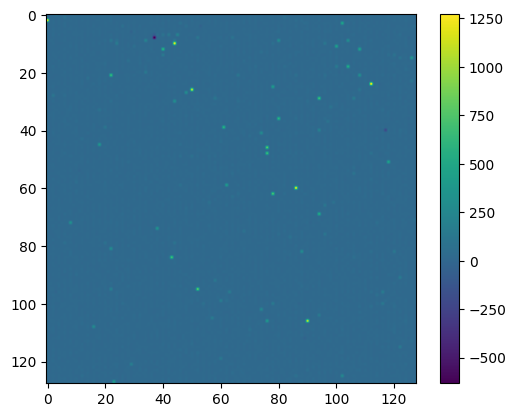

In [156]:
median_hband_dark = get_median_frame(hband_dict["darks"])
plt.imshow(median_hband_dark)
plt.colorbar()

## Hband Master Bias

## Hband Master Science

A collaborator contributed the following:
Dictionary of all usable files and our object's position in said files

posdict = {}
posdict["H"] = [(582, 597), (753, 722), (375, 610), (490, 407),
                (581, 596), (365, 405), (396, 607), (738, 412)]
posdict["J"] = [(626, 619), (479, 498), (500, 747), (794, 589)]
posdict["K"] = [(621, 611), (822, 600), (484, 782), (835, 411),
                (581, 596), (407, 439), (742, 429), (780, 796)]

The bulk of the code. I construct a few dictionaries with all the
possible master files and raw files. Those are the dictionaries that I
am referencing here, hopefully its clear.

def generate_outputs():
    bands = ["H", "J", "K"]
    mag_bands = {}
    for band in bands:
        mag_bands[band] = []
        hot_pixels = sigma_mask(masterdict[band]["darks"][1])[0]
        cold_pixels = sigma_mask(masterdict[band]["flats"][1])[0]
        bad_pixels = hot_pixels + cold_pixels
        bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
        for row in bad_mask:
            np.nan_to_num(row, 0)
        for index, file in enumerate(filedict[band]["sci"]):
            sky_no_background = fits.open(file)[0].data -
masterdict[band]["sci"][1]
            full_output = sky_no_background * (1 - bad_mask)
            hdu = fits.PrimaryHDU(full_output)
            path_input = './2M1207_bands/' + band + 'band/'
            path_output = path_input + 'out/'
            sep='/'
            file_id = file.replace(f"./2M1207_bands/{band}band/sci/",
'').replace('.fits','')
            hdu.writeto(path_output + file_id + '_out.fits', overwrite=True)
            cropped_output = crop_array(full_output,
posdict[band][index][1], posdict[band][index][0])
            mag_bands[band].append(determine_mag(cropped_output))
    return mag_bands

Cropping helper function, aligns image with its corresponding position
in the position dictionary. Builds a 2nx2n data array centered on the
object

def crop_array(datap, x_center, y_center):
    """
    Returns a cropped array of dimensions 2nx2n
    """
    n = 50
    return datap[x_center - n:x_center + n,y_center-n:y_center + n]

Function that generates the magnitude and flux values for the SED. The
code in the notebook originally had a shitty finding algorithm to find
the object but I found it to be inconsistent, so I used the fact that
the cropped images were very well aligned and manually defined the
aperture to be centered on the exoplanet. The exoplanet does not seem
to move all to much so it ends up working out

def determine_mag(data):
    bkg_sigma = mad_std(median_output)
    filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
    daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 2.0*bkg_sigma)
    sources = daofind(data)
    for col in sources.colnames:
        sources[col].info.format = '%.8g'

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture([[25.73661874, 32.59190509],[49.5,
49.5]], r=filter_fwhm)
    phot_table = aperture_photometry(data, apertures)
    plt.figure(figsize = [20,20])
    plt.imshow(data,vmin=0,vmax=20,cmap='hot')
    plt.colorbar()
    apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    planet_counts = np.min(phot_table["aperture_sum"])
    star_counts = np.max(phot_table["aperture_sum"])
    FluxRatio = planet_counts / star_counts
    print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)
    return -2.5*np.log10(FluxRatio) + 12.388

Some of the lines in the function may be deprecated so there is some
stuff you can trim out.

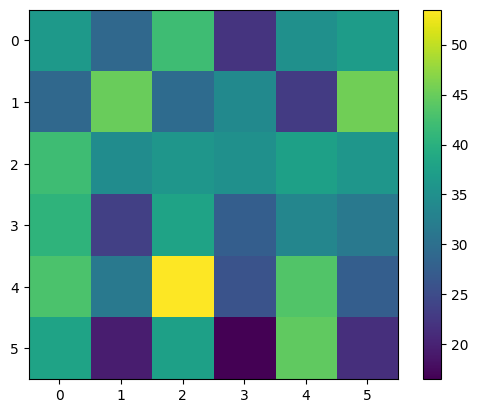

In [152]:
df = pd.DataFrame(hband_dict["sci"][0])
bounds = 3
test = df.iloc[582-bounds:582+bounds, 597-bounds:597+bounds].to_numpy()
plt.imshow(test)
plt.colorbar()

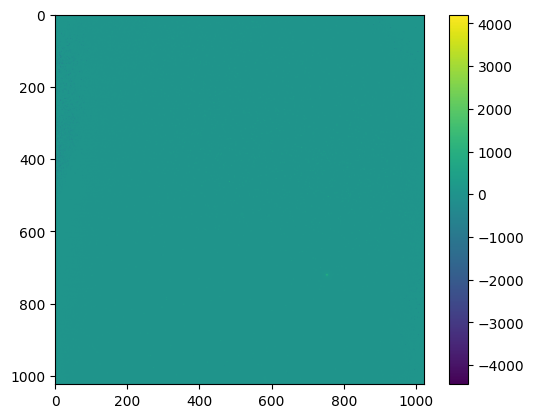

In [141]:
plt.imshow(hband_dict["sci"][-1])
plt.colorbar()

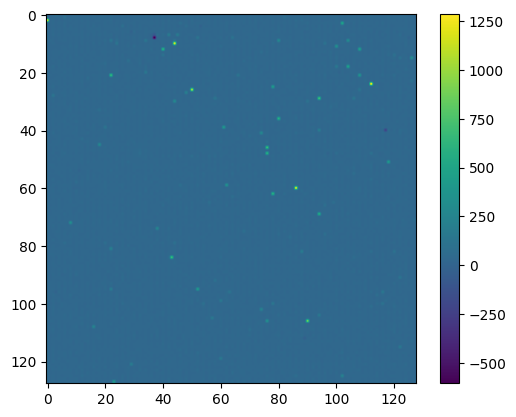

In [134]:
median_hband_sci = get_median_frame(hband_dict["sci"])
plt.imshow(median_hband_sci)
plt.colorbar()

In [113]:
hband_dict.keys()

dict_keys(['flats', 'flat darks', 'sci', 'darks'])

 id xcentroid ycentroid ... flux mag 
--- --------- --------- ... ---- ----
  1 71.379434 3.4890241 ...  inf -inf
  2 88.160147 4.5312896 ...  inf -inf
  3 105.04465 4.5991483 ...  inf -inf
...       ...       ... ...  ...  ...
 50 90.845834 109.05421 ...  inf -inf
 51 10.668109 115.69465 ...  inf -inf
 52  51.85229 120.12478 ...  inf -inf
 53 57.893846 120.03533 ...  inf -inf
Length = 53 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 71.379434 3.4890241    68761.483
  2 88.160147 4.5312896    67243.436
  3 105.04465 4.5991483    68098.469
...       ...       ...          ...
 51 10.668109 115.69465    69884.669
 52  51.85229 120.12478     69215.65
 53 57.893846 120.03533    68290.126
Length = 53 rows


/home/ubuntu/.conda/envs/vipenv/lib/python3.9/site-packages/photutils/detection/daofinder.py:628: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


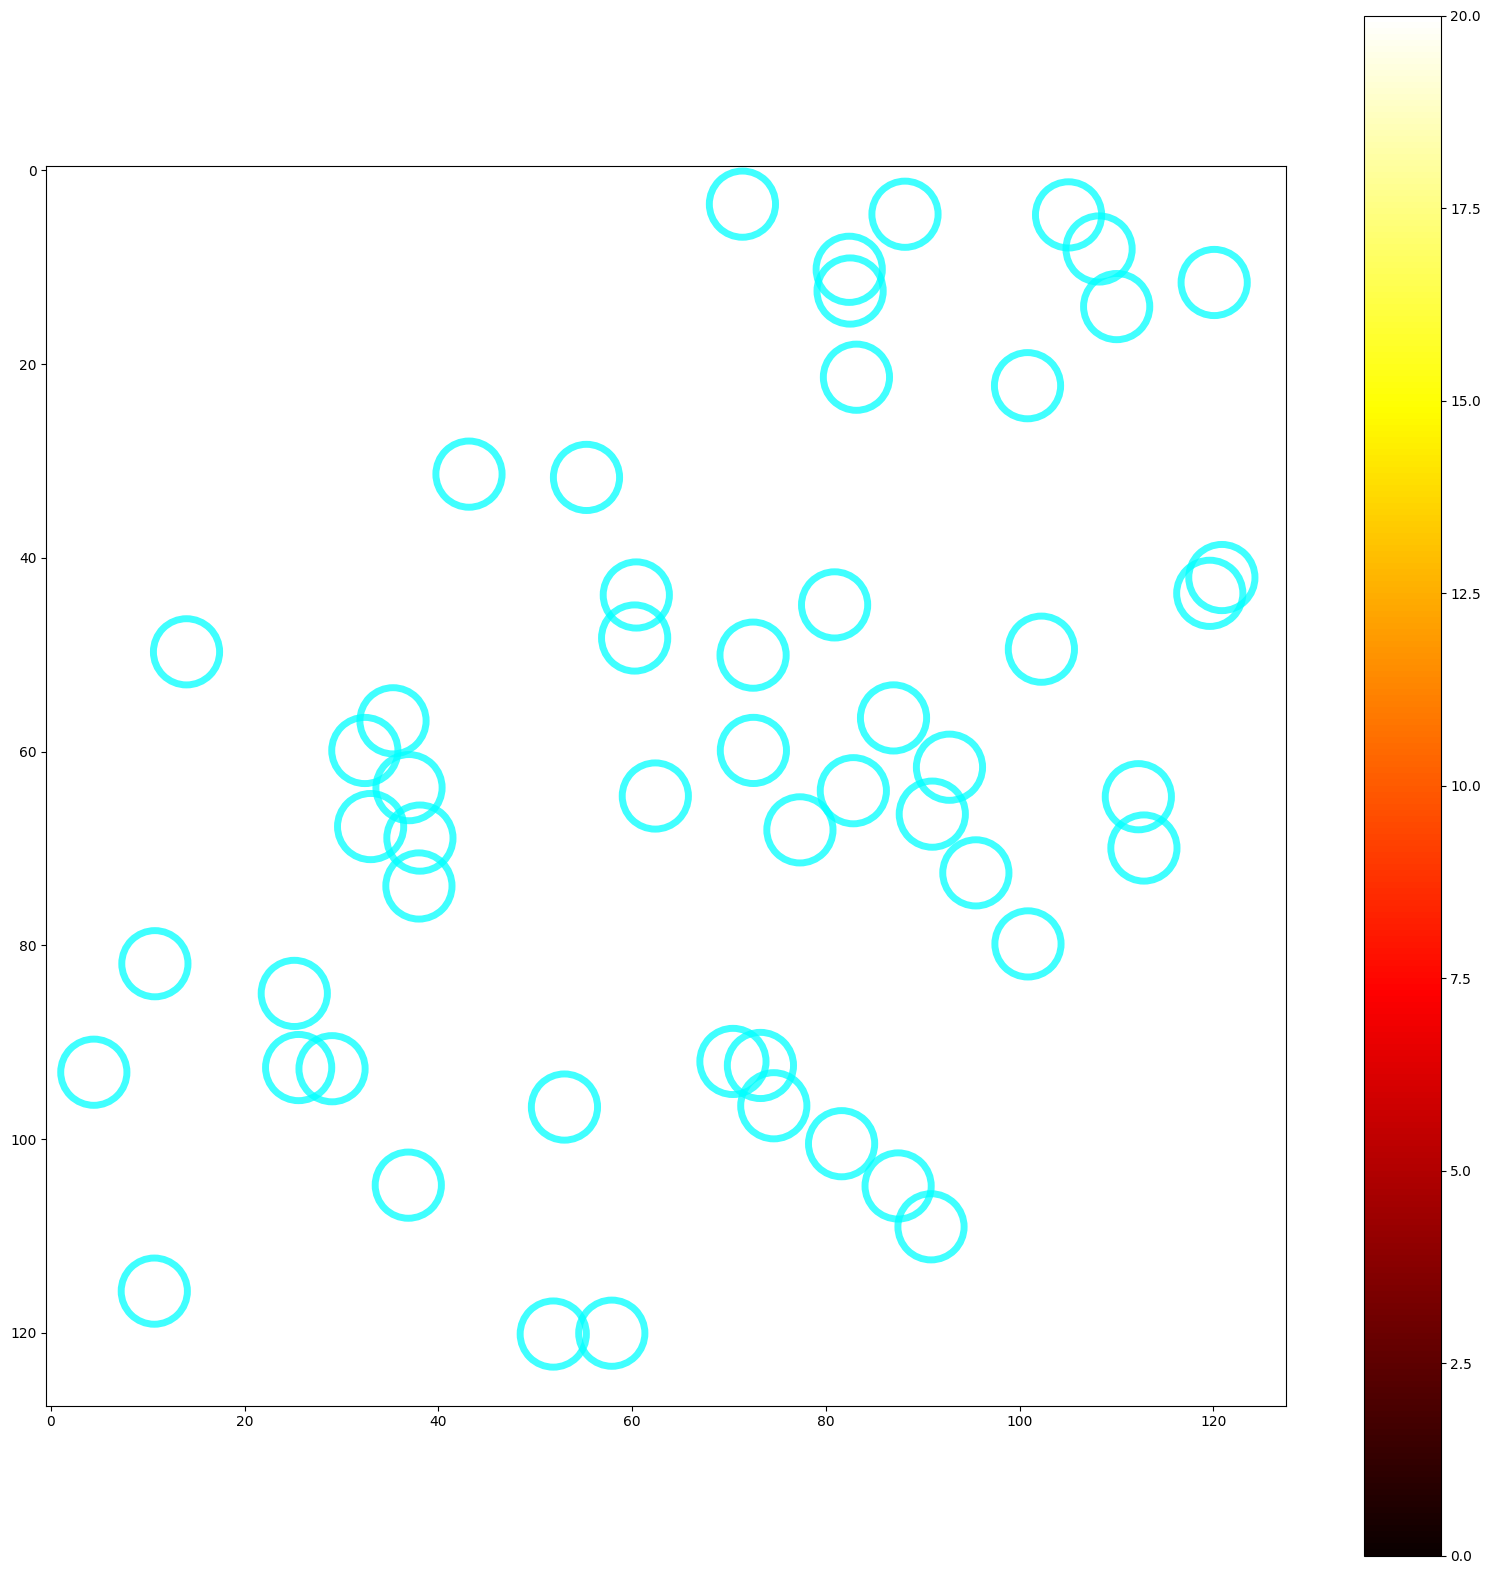

In [106]:
from photutils import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(final_image_cropped)
filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 3.0*bkg_sigma)
sources = daofind(final_image_cropped)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=filter_fwhm)
phot_table = aperture_photometry(final_image_cropped, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

plt.figure(figsize = [20,20])
plt.imshow(final_image_cropped,vmin=0,vmax=20,cmap='hot')
plt.colorbar()
apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)

In [27]:
print(bkg_sigma)
FluxRatio = phot_table[1][3]/phot_table[2][3]
print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)

1.2349174286296776
Planet Mag =  nan


<ipython-input-27-dc86989db42c>:3: RuntimeWarning: invalid value encountered in log10
  print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)
